In [1]:
#pip install keras

In [2]:
#pip install scikit-learn

In [3]:
#pip install matplotlib

In [4]:
#pip install tensorflow

In [5]:
#pip install pathlib

In [6]:
#pip install PIL

## Adapted from https://towardsdatascience.com/how-to-cluster-images-based-on-visual-similarity-cd6e7209fe34

In [7]:
# for loading/processing the images  
#from keras.preprocessing.image import load_img    ##depreciated
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.utils import img_to_array 
from keras.applications.vgg16 import preprocess_input 

# models 
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19 
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle
import pathlib
import PIL

In [8]:
path = r"C:\Users\dunphsi1\OneDrive - Novartis Pharma AG\Data Science Course\699\Images 3\Images" ###Local path, will need to update
os.chdir(path)

# this list holds all the image filename
images = []

# creates a ScandirIterator aliased as files
with os.scandir(path) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.jpg'):
          # adds only the image files to the flowers list
            images.append(file.name)

len(images)

11302

In [9]:
# load the image as a 224x224 array
img = load_img(images[0], target_size=(224,224))
# convert from 'PIL.Image.Image' to numpy array
img = np.array(img)

print(img.shape)
(224, 224, 3)

reshaped_img = img.reshape(1,224,224,3)
print(reshaped_img.shape)
(1, 224, 224, 3)

x = preprocess_input(reshaped_img)

(224, 224, 3)
(1, 224, 224, 3)


In [11]:
# load model
model16 = VGG16()
# remove the output layer
model16 = Model(inputs=model16.inputs, outputs=model16.layers[-2].output)

In [12]:
# load model
model19 = VGG19()
# remove the output layer
model19 = Model(inputs=model19.inputs, outputs=model19.layers[-2].output)

In [13]:
def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [14]:
#VGG16 takes about 2 hours to run, VGG19 about 90 mintues. Downloaded the features achieved and will Load these from a csv instead to save time
data = {}
p = r"C:\Users\dunphsi1\OneDrive - Novartis Pharma AG\Data Science Course\699\Images_3_features.pkl"

# lop through each image in the dataset
for image in images:
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(image,model16) ### CHANGE MODEL HERE AS NEEDED
        data[image] = feat
    # if something fails, save the extracted features as a pickle file (optional)
    except:
        with open(p,'wb') as file:
            pickle.dump(data,file)

# get a list of the filenames
filenames = np.array(list(data.keys()))

# get a list of just the features
feat = np.array(list(data.values()))
feat.shape
(210, 1, 4096)

# reshape so that there are 210 samples of 4096 vectors
feat = feat.reshape(-1,4096)
feat.shape
(210, 4096)

1/1 [==============================] - 1s 942ms/step


(210, 4096)

In [40]:
#type(feat)

numpy.ndarray

In [22]:
#feat

## Next two cells were for saving the results from the VGG model so they can be loaded without re-running the model

In [15]:
# import pandas as pd
# pd.DataFrame(feat).to_csv(r"C:\Users\dunphsi1\OneDrive - Novartis Pharma AG\Data Science Course\699\vgg16_feat_file.csv")
# pd.DataFrame(filenames).to_csv(r"C:\Users\dunphsi1\OneDrive - Novartis Pharma AG\Data Science Course\699\vgg16_filenames_file.csv")

In [3]:
#Use this to just load the features and filenames for use with the PCA + KMenas clustering. Replace with path to files

#feat = pd.read_csv(r"C:\Users\dunphsi1\OneDrive - Novartis Pharma AG\Data Science Course\699\vgg16_feat_file.csv")
#filenames = pd.read_csv(r"C:\Users\dunphsi1\OneDrive - Novartis Pharma AG\Data Science Course\699\vgg16_filenames_file.csv")

In [31]:
#Apply PCA to reduce feature space
pca = PCA(n_components=100, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

In [35]:
#kmeans clustering

kmeans = KMeans(n_init = 'auto',n_clusters=40, random_state=22)
kmeans.fit(x)

groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

#

In [29]:
#Saving the labels 

# type(kmeans.labels_)
# pd.DataFrame(kmeans.labels_).to_csv(r"C:\Users\dunphsi1\OneDrive - Novartis Pharma AG\Data Science Course\699\vgg16_PCA50_labels40_file.csv")

In [36]:
# function that lets you view a cluster (based on identifier)        
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 10:
        #print(f"Clipping cluster size from {len(files)} to 10")
        files = files[:9]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

C:\Users\dunphsi1\AppData\Local\Temp\1\ipykernel_7832\3654916159.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize = (25,25));


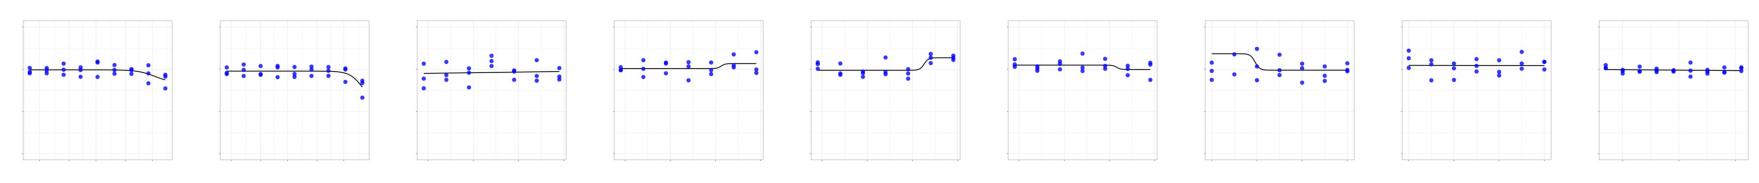

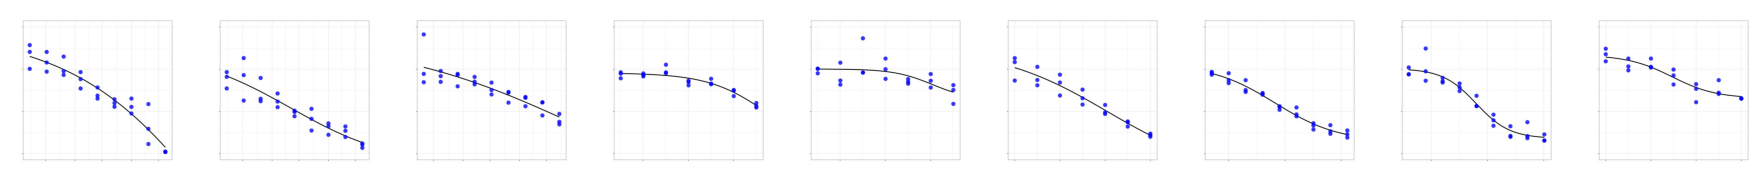

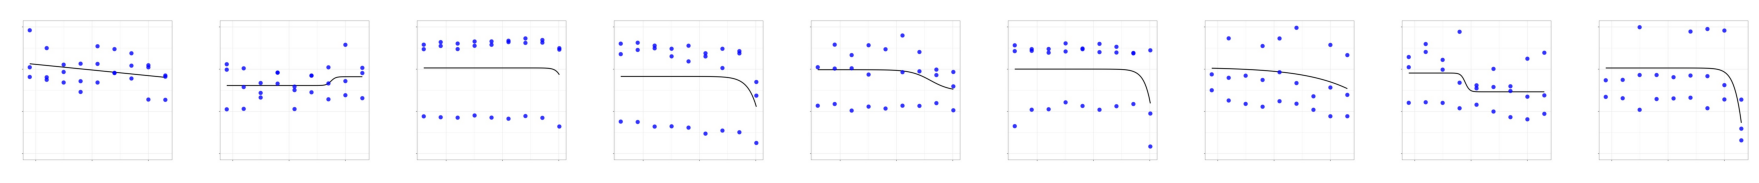

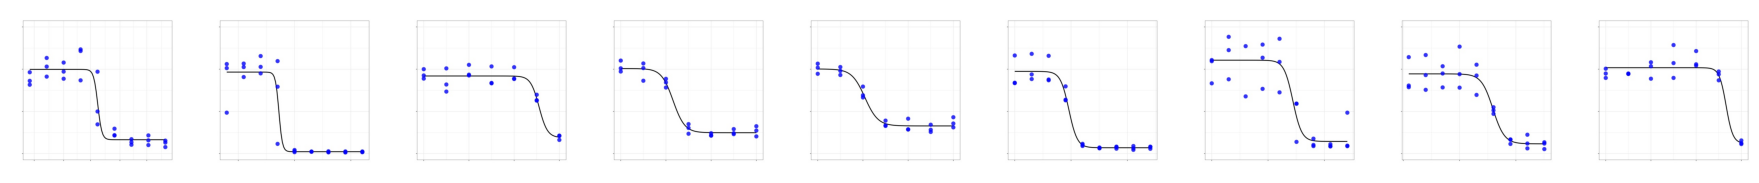

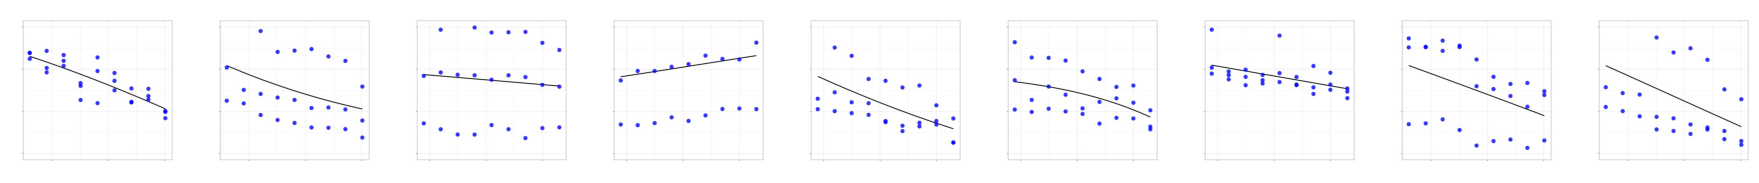

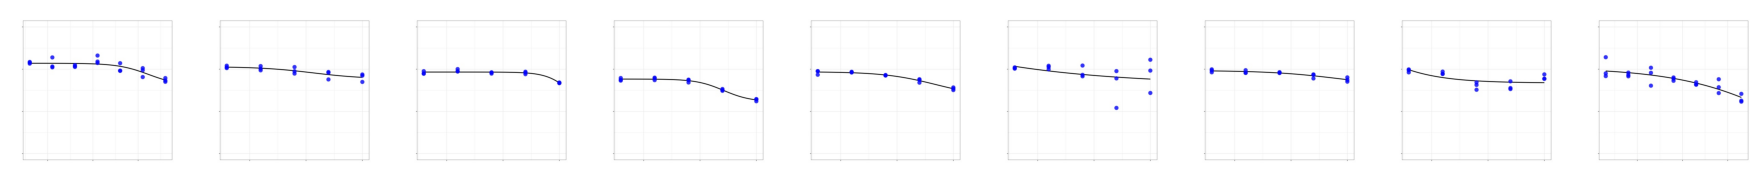

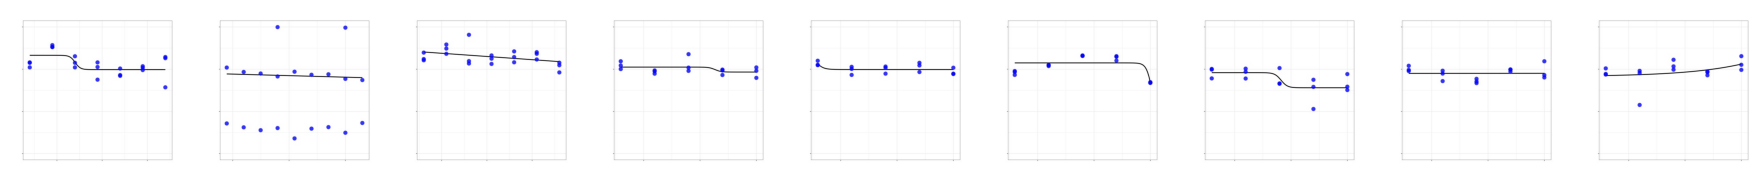

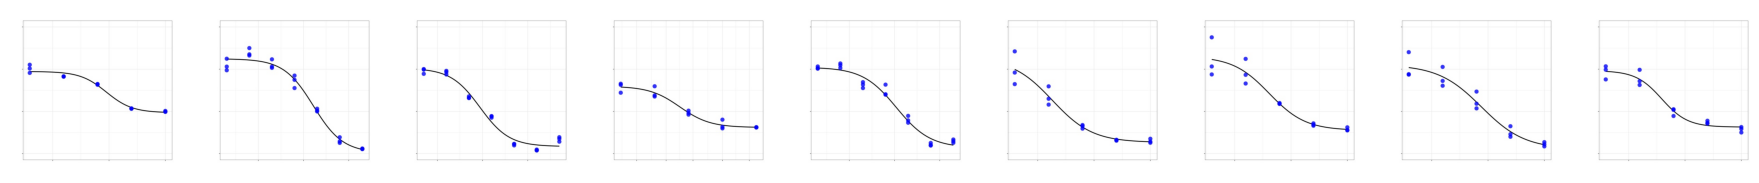

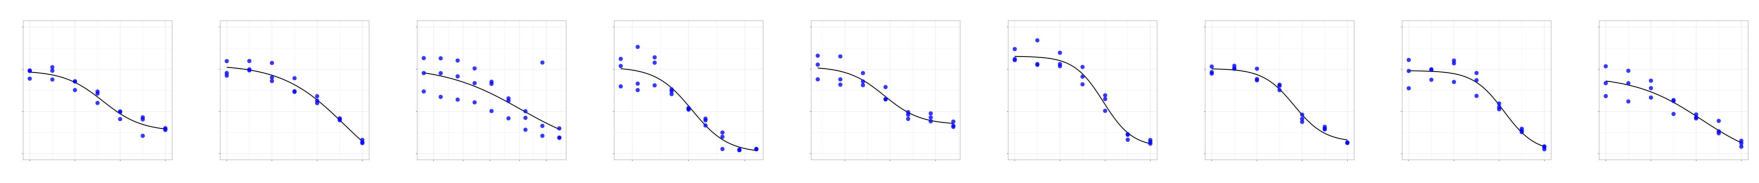

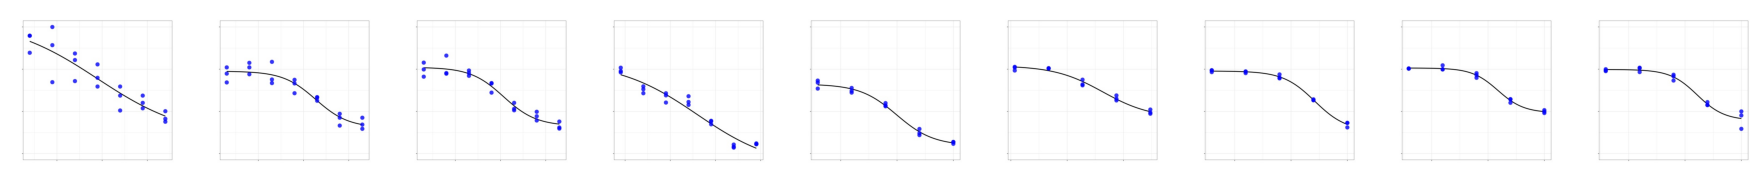

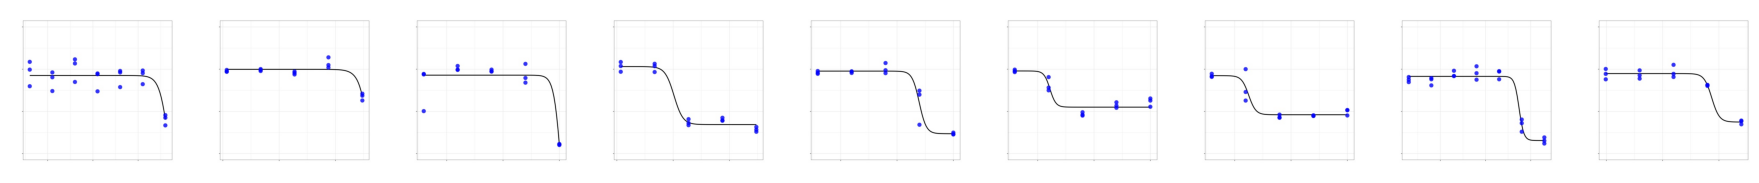

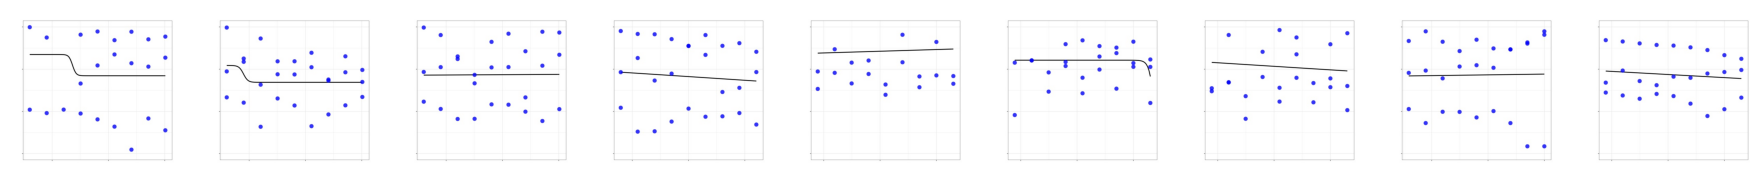

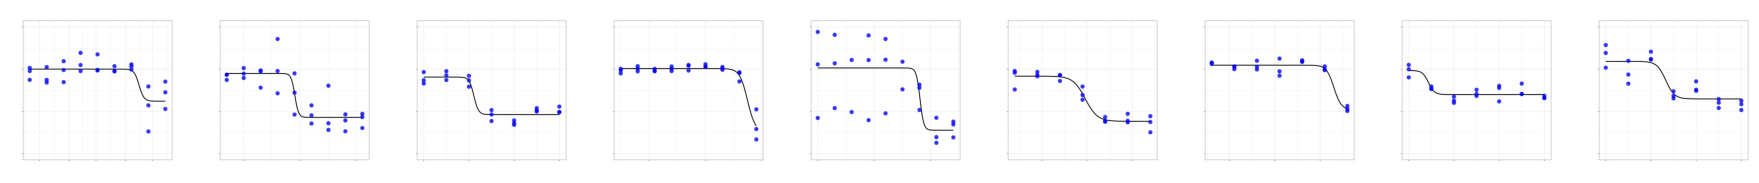

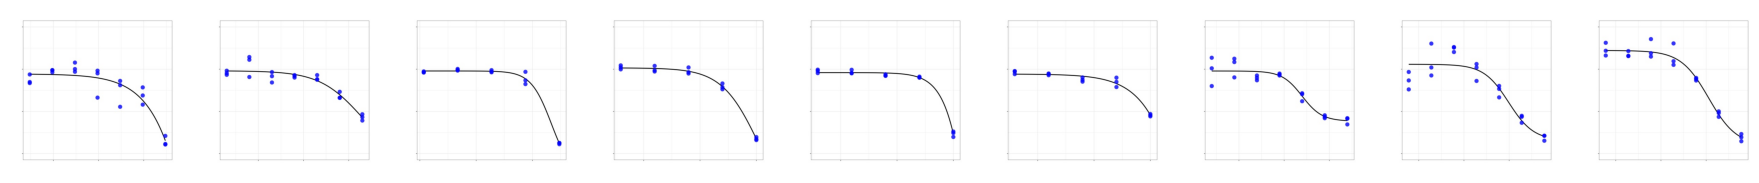

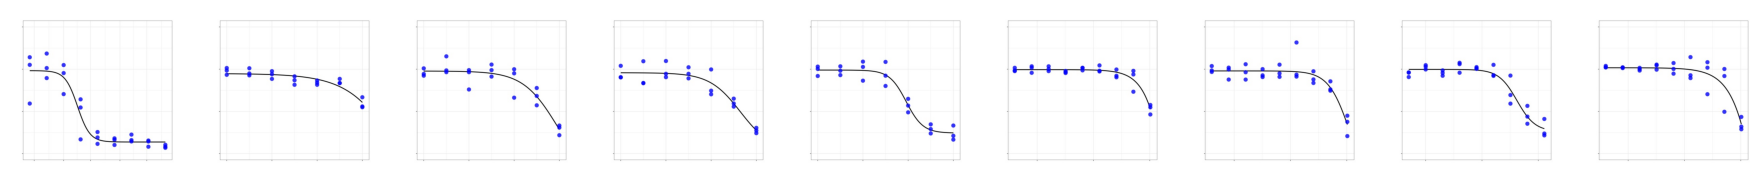

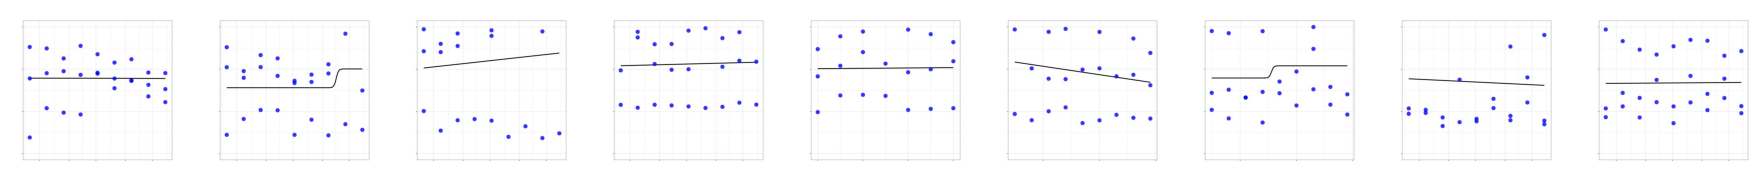

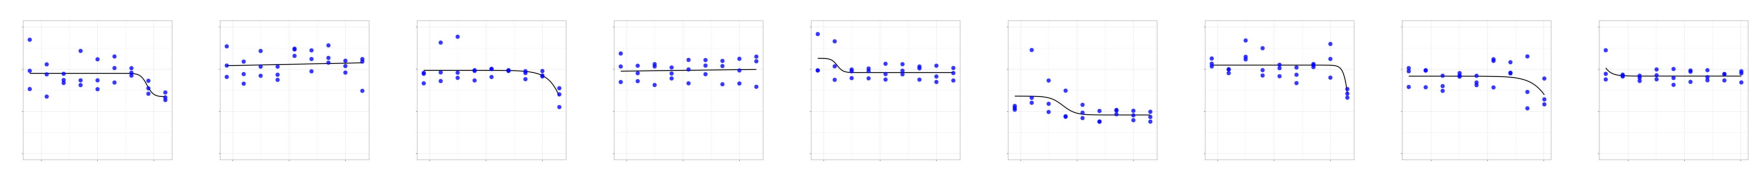

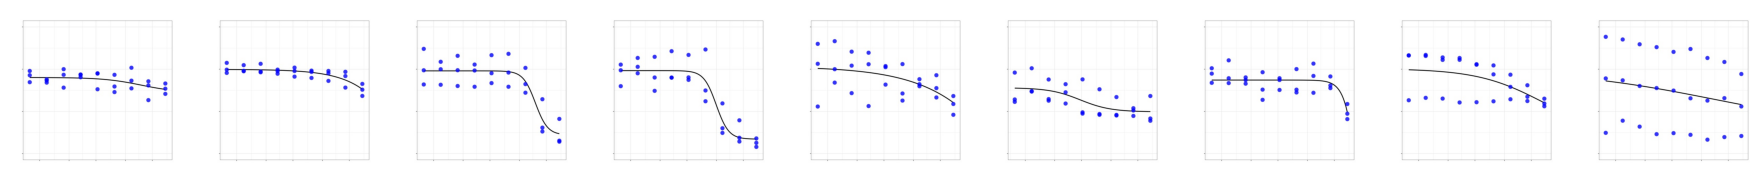

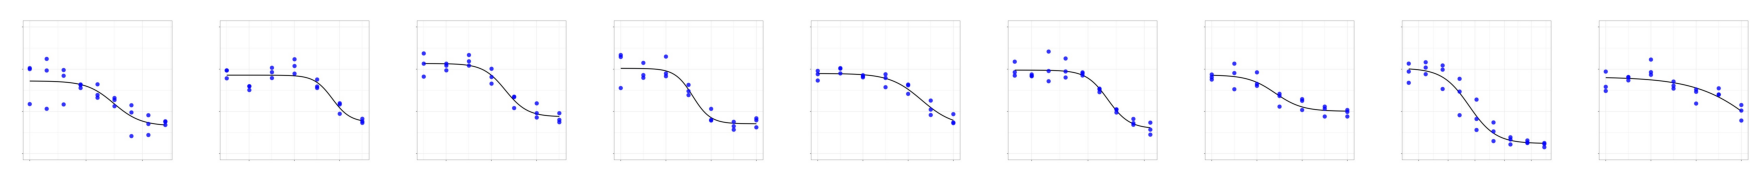

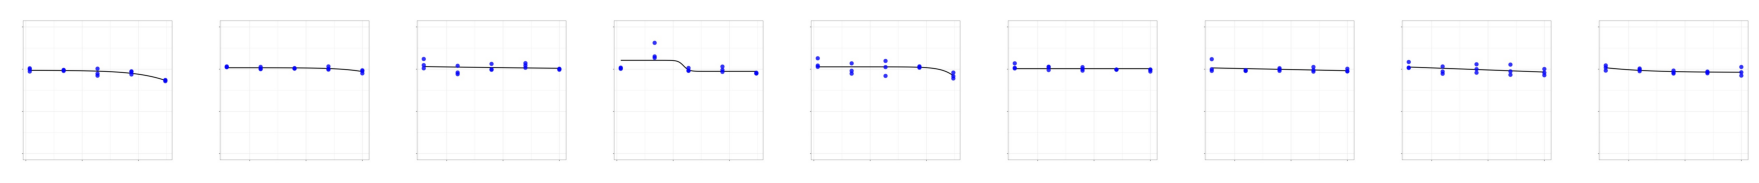

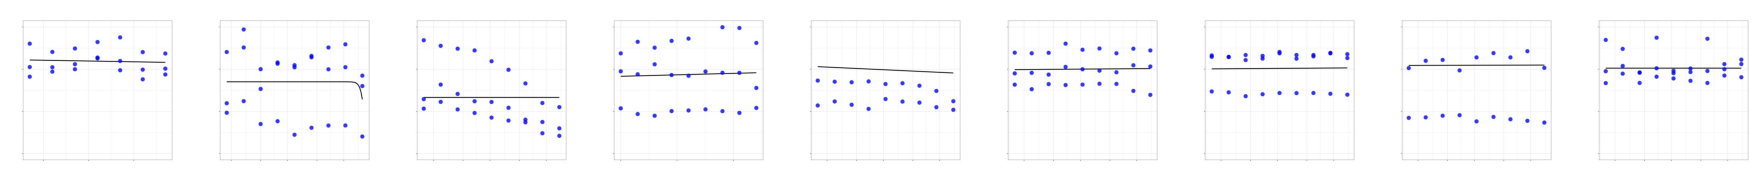

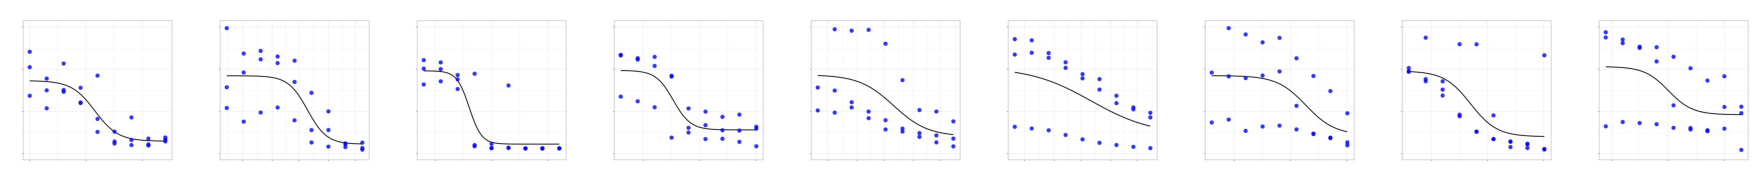

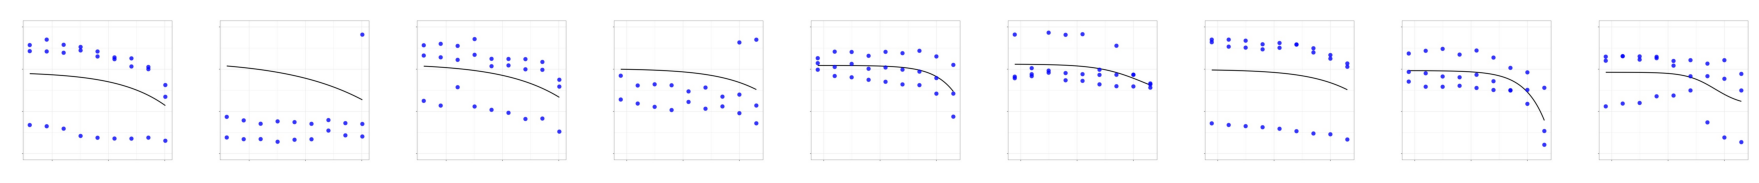

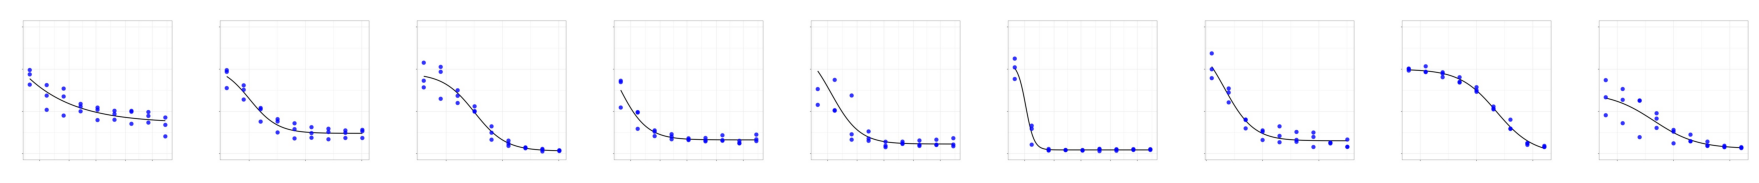

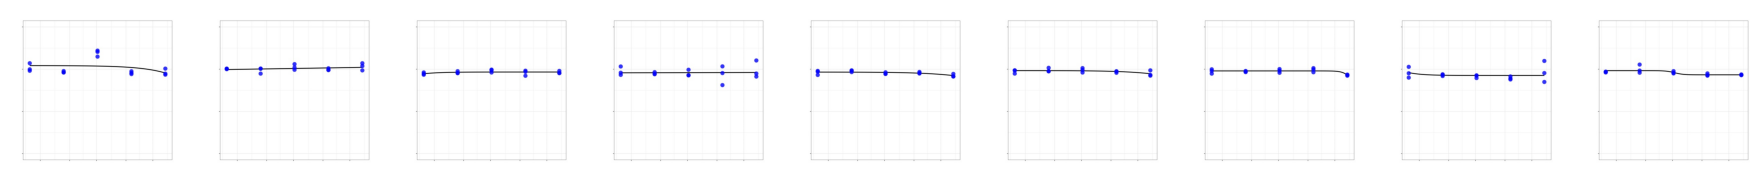

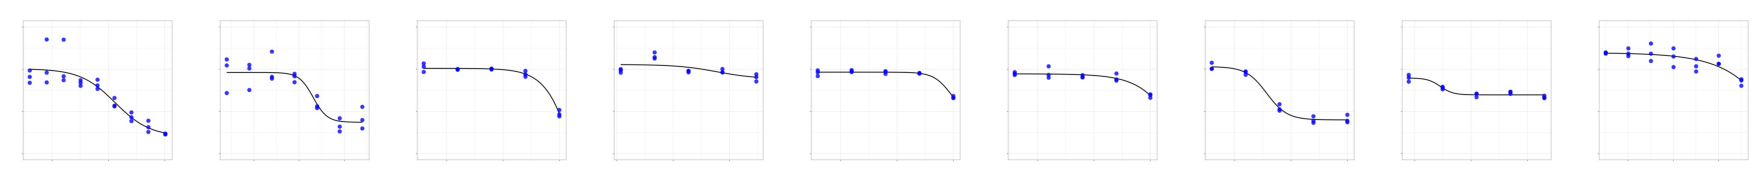

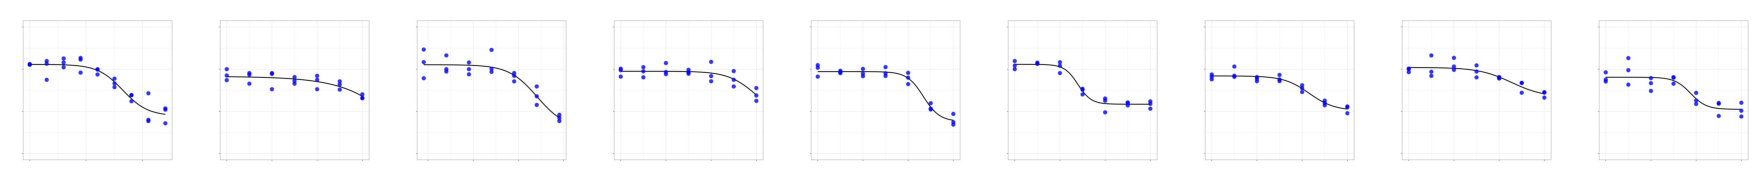

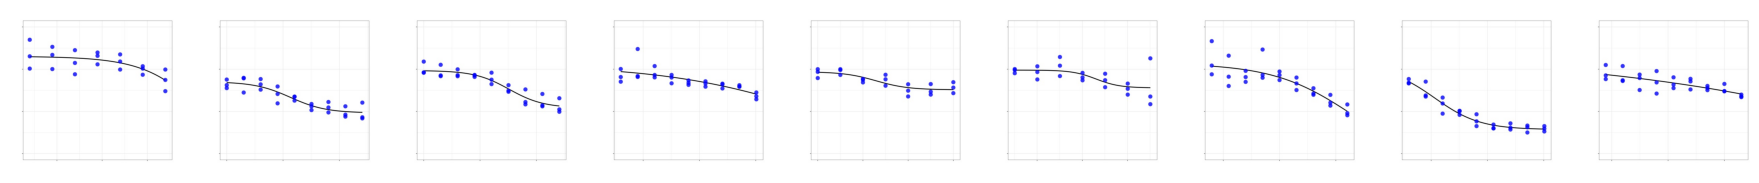

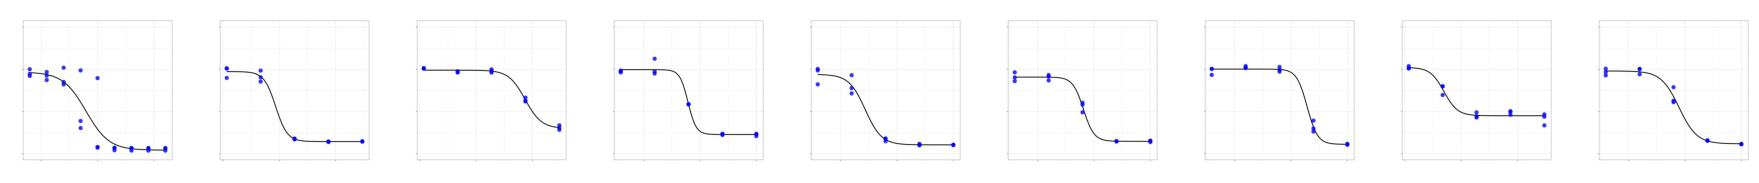

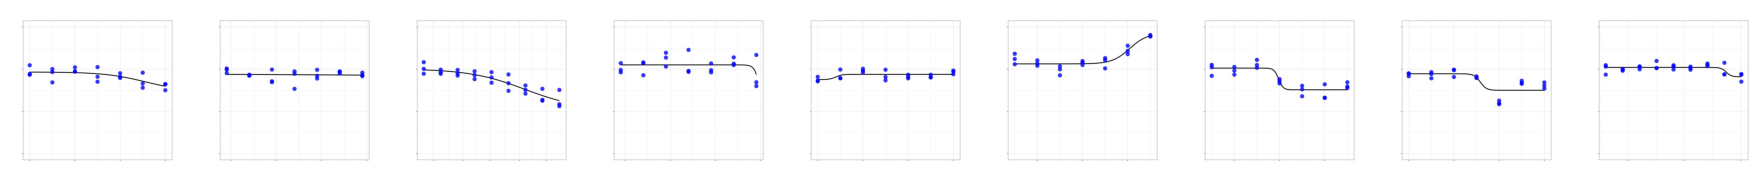

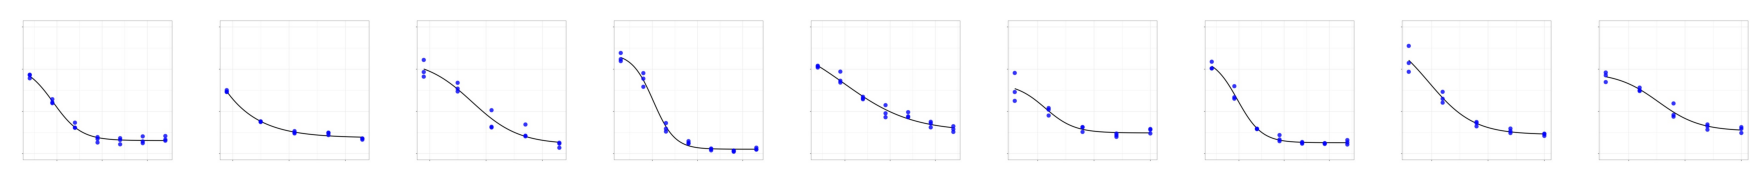

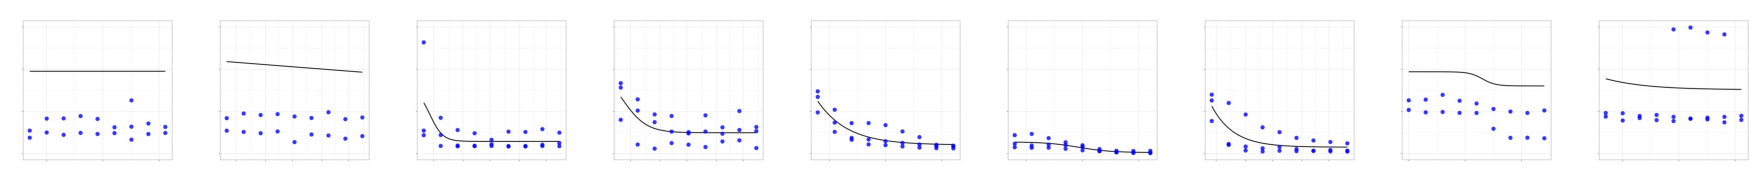

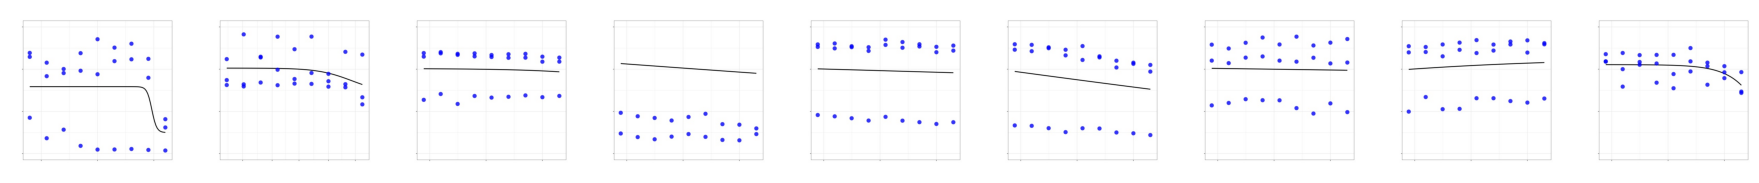

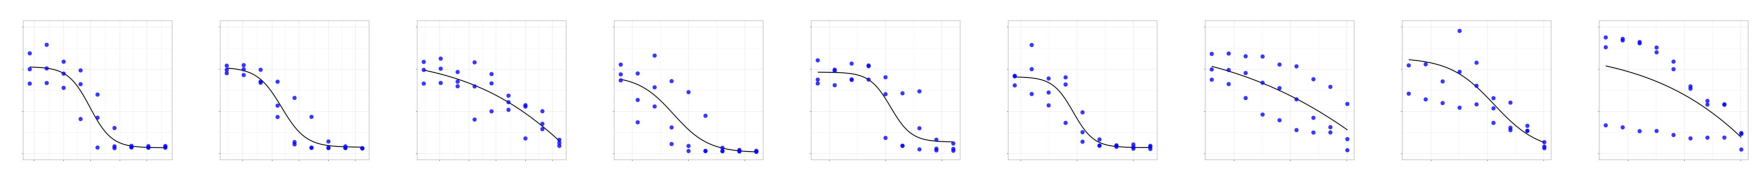

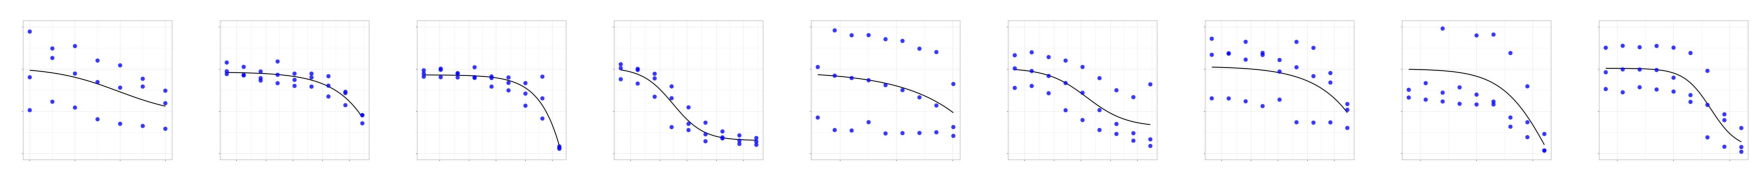

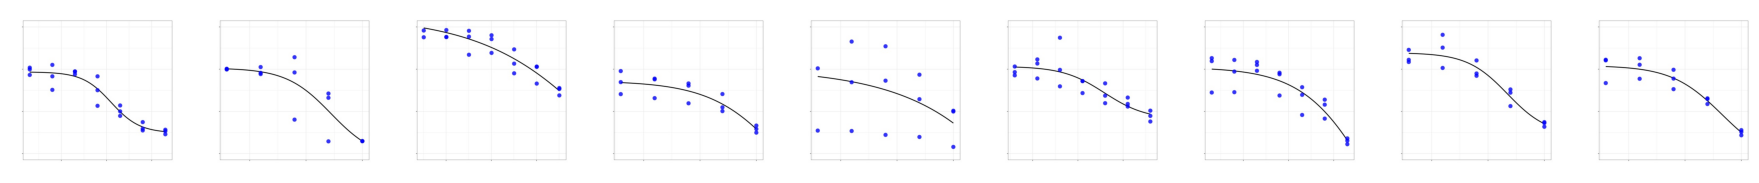

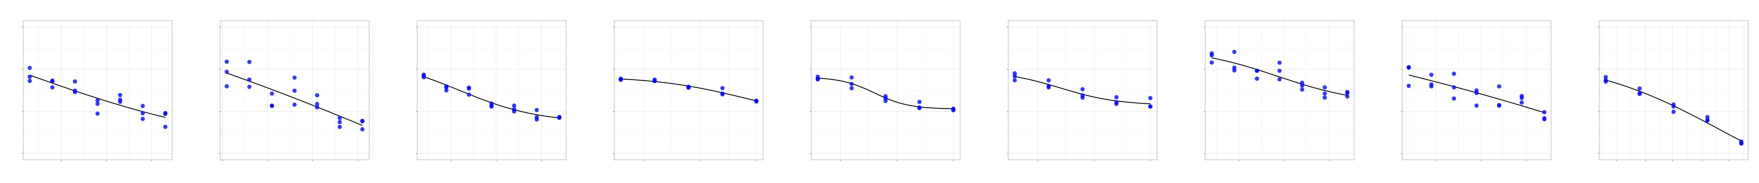

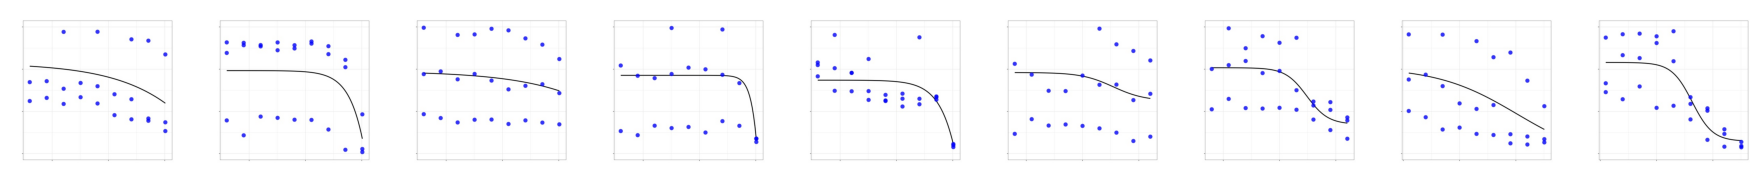

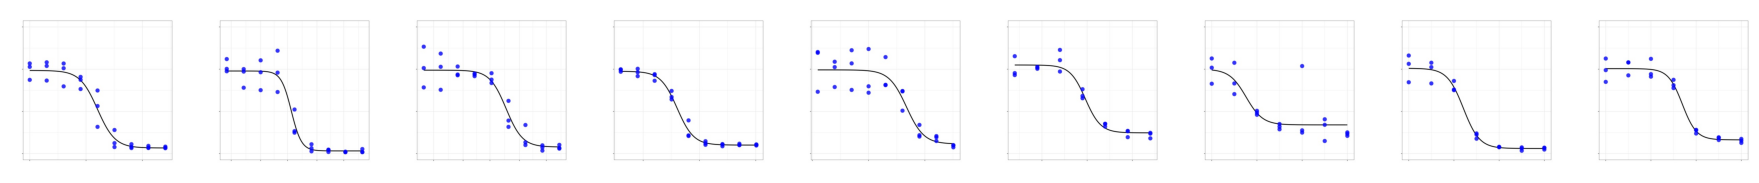

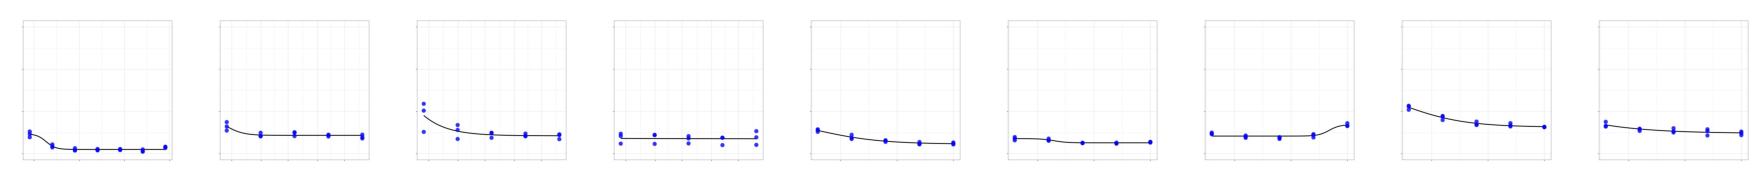

In [37]:
for cluster in range(len(groups)):
    #print("CLUSTER ",cluster)
    view_cluster(cluster)

## Manually assigning labels to the clusters and then creating a pandas df with a label for each image to use for supervised leaarning

In [38]:
Rating_dict_vgg16_40_clusters = {
    0:'Bad',1:'Medicore',2:'Bad',3:'Medicore',4:'Bad',5:'Bad',6:'Bad',7:'Medicore',8:'Medicore',9:'Medicore',10:'Medicore',
    11:'Bad',12:'Medicore',13:'Medicore',14:'Bad',15:'Bad',16:'Bad',17:'Bad',18:'Medicore',19:'Bad',20:'Bad',
    21:'Bad',22:'Bad',23:'Medicore',24:'Bad',25:'Bad',26:'Medicore',27:'Medicore',28:'Good',29:'Bad',30:'Medicore',
    31:'Bad',32:'Bad',33:'Bad',34:'Bad',35:'Medicore',36:'Medicore',37:'Bad',38:'Good',39:'Bad'}


In [40]:
# len(filenames)
# len(kmeans.labels_)

11302

In [41]:
groups[0][0]

'image_10014.jpg'

In [43]:
filenames[0]

'image_0.jpg'

In [44]:
kmeans.labels_[0]

27

In [58]:
labels_df = pd.DataFrame(filenames,kmeans.labels_).reset_index().rename(columns={'index':"Cluster #",0:"Image"})
labels_df['Label'] = labels_df['Cluster #'].map(Rating_dict_vgg16_40_clusters)
labels_df.head()

,Cluster #,Image,Label
0,27,image_0.jpg,Medicore
1,6,image_1.jpg,Bad
2,20,image_10.jpg,Bad
3,34,image_100.jpg,Bad
4,29,image_1000.jpg,Bad


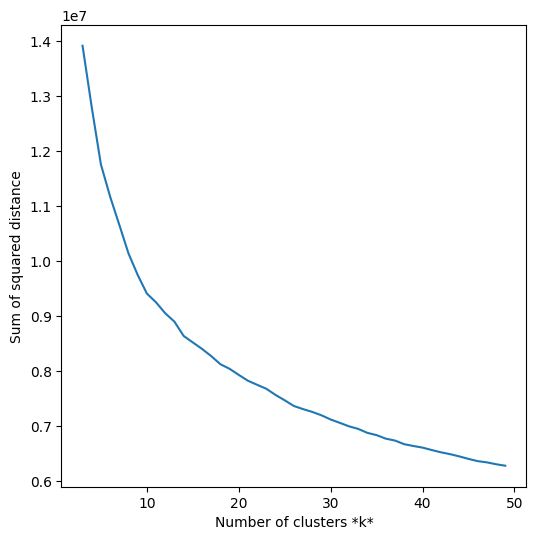

In [29]:
# this is just incase you want to see which value for k might be the best 
sse = []
list_k = list(range(3, 50))

for k in list_k:
    km = KMeans(n_init = 'auto', n_clusters=k, random_state=22)
    km.fit(x)
    
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse)
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');